# Final Project for Stochastic Hydrology: Low Flows
Spring 2021

The purpose of this notebook is to find 7-day low flows from historical and climate change conditions both with and without reservoir operations. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import utils
from astropy.stats import bootstrap as bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
from mk_test import mk_test
import os

## 1. Historical Conditions

### Plot Flow Timeseries

In [49]:
files = [f for f in sorted(glob('../Data/baseline*'))]
allQ = pd.DataFrame()
for f in files:
    df = pd.read_csv(f)
    allQ[os.path.basename(f)[:-4]] = df['flow']
allQ.index = pd.to_datetime(df.date)

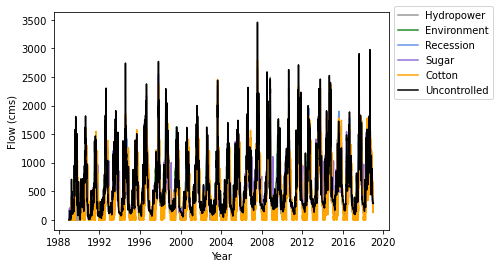

In [50]:
Objectives = ['Hydropower', 'Environment', 'Recession', 'Sugar', 'Cotton', 'Uncontrolled'] 
colors = ['#999999', "forestgreen", "cornflowerblue", "mediumpurple", "orange", "black"]

col_dict = {'Hydropower':'#999999', 'Environment':'forestgreen', 'Recession':'cornflowerblue', 'Sugar':'mediumpurple', 'Cotton':'orange', 'Uncontrolled':'black'}
for col,lab,c in zip(allQ.columns,Objectives,colors):
    plt.plot(allQ.index, allQ[col], label=lab, color=c)
plt.legend(bbox_to_anchor=(1,1.05))
plt.xlabel("Year")
plt.ylabel("Flow (cms)")
plt.show()

The lines are a little hard to see, but we can see that the scenario with the best reservoir operations for the cotton objective is exacerbating low flows. Uncontrolled seems to have the highest flows. 

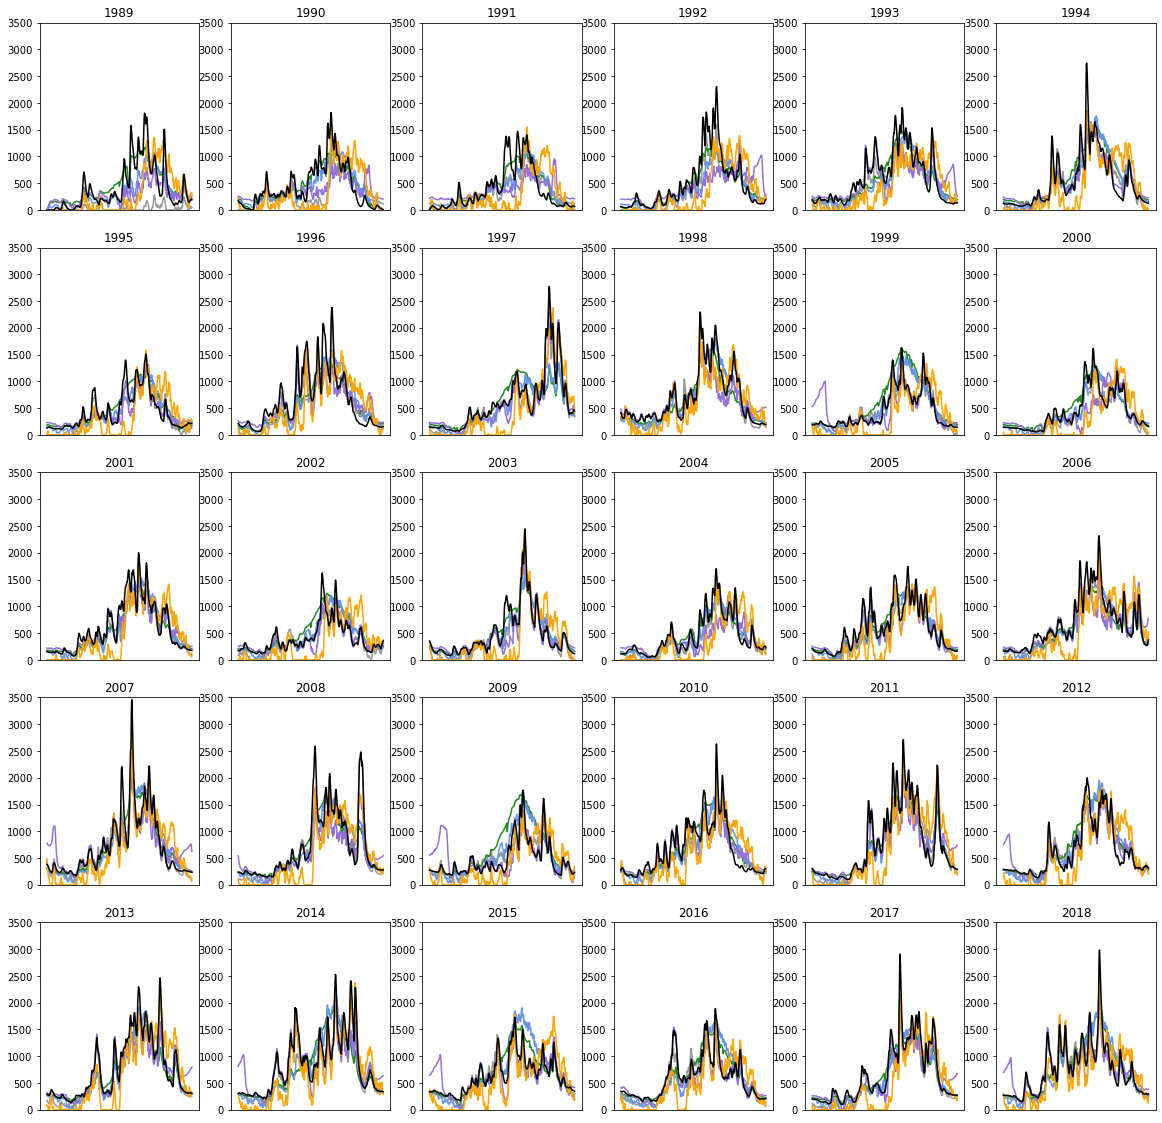

In [51]:
allQ.columns = Objectives

fig, axes = plt.subplots(5,6)
fig.set_size_inches(20,20)
for col,lab,c in zip(allQ.columns,Objectives,colors):
    for year,(a,ax) in zip(allQ.index.year.unique(), enumerate(axes.flat)):
        df = allQ[allQ.index.year == year]
        ax.plot(df.index, df[col], color=c)
        ax.set_ylim(0,3500)
        ax.xaxis.set_ticks([])
        ax.set_title(year)

### Get Annual 7-Day Low Flows

In [52]:
# find year of each data point
allQ['Year'] = allQ.index.year

# function to calculate sevenQ for given dataframe, column name, and endYear
def sevenQ(df, col, endYear):
    nyears = endYear - df['Year'][0]
    years = np.arange(df['Year'][0], df['Year'][0] + nyears, 1) 
    min7dayQ = np.zeros(nyears)
    for i,year in enumerate(years):
        yearlyFlows = df[col][np.where(df['Year']==year)[0]]
        sevenDayQ = np.zeros(len(yearlyFlows)-7+1)
        for j in range(len(sevenDayQ)):
            sevenDayQ[j] = np.sum(yearlyFlows[j:(j+7)])
        min7dayQ[i] = np.min(sevenDayQ)
    return min7dayQ

In [53]:
# calculate sevenQ for each year historical
historical_sevenQ = pd.DataFrame()
for col in allQ.columns[:-1]:
    print(col)
    historical_sevenQ[col] = sevenQ(allQ, col, 2019) 

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


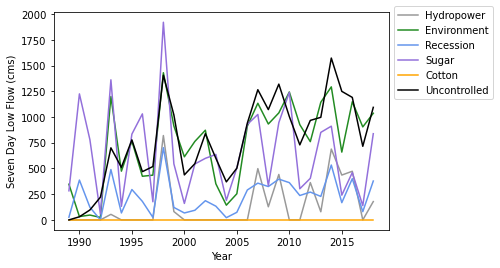

In [54]:
historical_sevenQ.index = np.unique(allQ.Year)
for col,lab,c in zip(historical_sevenQ.columns,Objectives,colors):
    plt.plot(historical_sevenQ.index, historical_sevenQ[col], label=lab, color=c)
plt.legend(bbox_to_anchor=(1,1.05))
plt.xlabel("Year")
plt.ylabel("Seven Day Low Flow (cms)")
plt.show()

The policy that is best for cotton has 0 as the sevenQ flow for all years. The policy that's best for hydropower also is generally quite low. The policy that's best for environmental flows unsurprisingly has the closest sevenQ flow over history since it is trying to mimic historical conditions. 

There does look like therecould be a trend of increasing seven day low flows. 

### Trend Analysis Seven Day Low Flows

I'll need to start by checking if the seven day low flows are normally distributed.

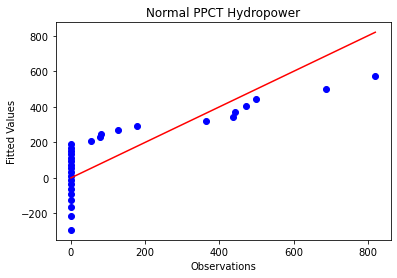

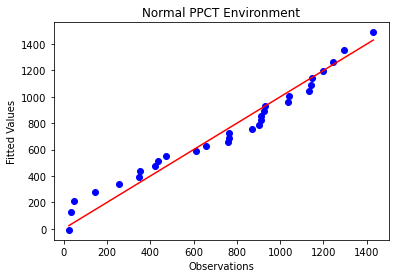

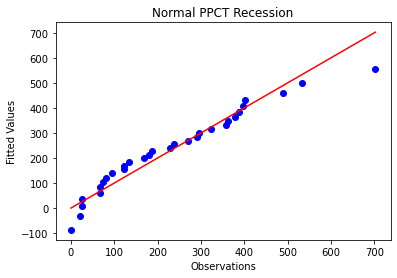

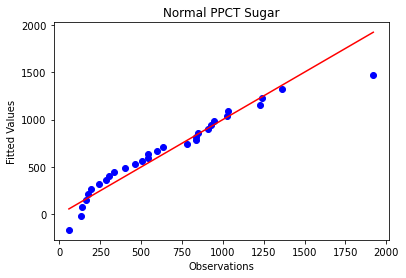

C:\Users\smj5vup\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\smj5vup\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\smj5vup\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


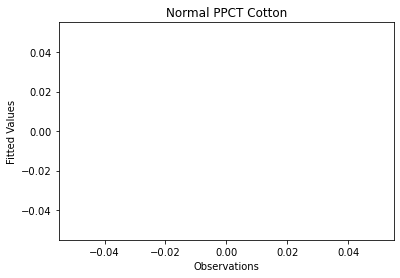

C:\Users\smj5vup\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


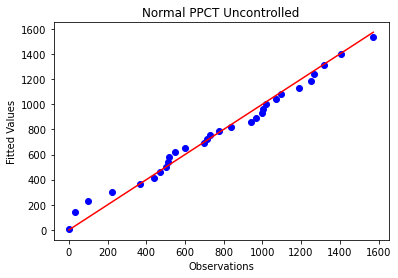

In [9]:
rhos = dict.fromkeys(historical_sevenQ.columns)
p_vals = dict.fromkeys(historical_sevenQ.columns)

for col in historical_sevenQ.columns:
    mu, sigma = utils.fitNormal(historical_sevenQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(historical_sevenQ[col], mu, sigma, 'Normal PPCT %s' % col, '../Figures/NormalPPCT_%s.png' % col)
    rhos[col] = rho
    p_vals[col] = p_value

In [10]:
p_vals

{'Hydropower': 0.0,
 'Environment': 0.42179999999999995,
 'Recession': 0.13260000000000005,
 'Sugar': 0.08279999999999998,
 'Cotton': 1.0,
 'Uncontrolled': 0.9609}

Try transformation? 

I'll have to take out cotton and hydropower except for non-parametric tests.


Look at ACF/PCF

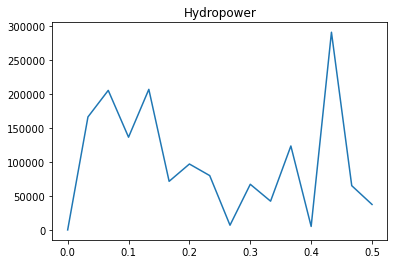

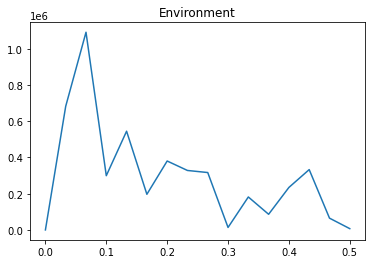

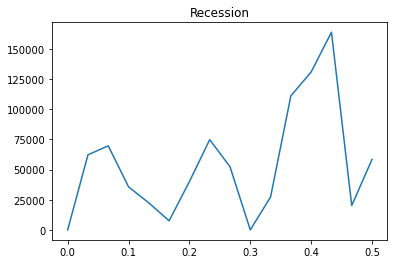

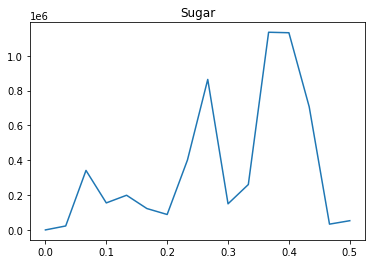

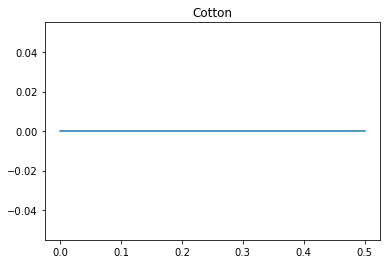

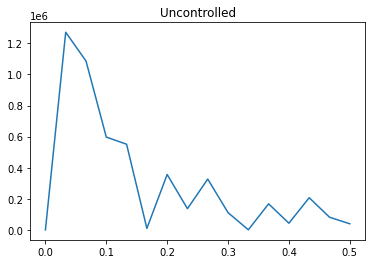

In [11]:
# look at periodogram of transformed annual maxima
for col in historical_sevenQ.columns:
    f, P = scipy.signal.periodogram(historical_sevenQ[col])
    plt.plot(f,P)
    plt.title(col)
    plt.show()

Psorted = np.argsort(P)[::-1] # sort from largest to smallest
Psorted = Psorted[Psorted > 0] # filter 0 vals
T = 1/f[Psorted] # find corresponding periods

In [12]:
T

array([30.        , 15.        , 10.        ,  7.5       ,  5.        ,
        3.75      ,  2.30769231,  2.72727273,  4.28571429,  3.33333333,
        2.14285714,  2.5       ,  2.        ,  6.        ,  3.        ])

Look at the ACF and PCF

<ipython-input-13-8fcaa2dc3c51>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-8fcaa2dc3c51>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-8fcaa2dc3c51>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-8fcaa2dc3c51>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


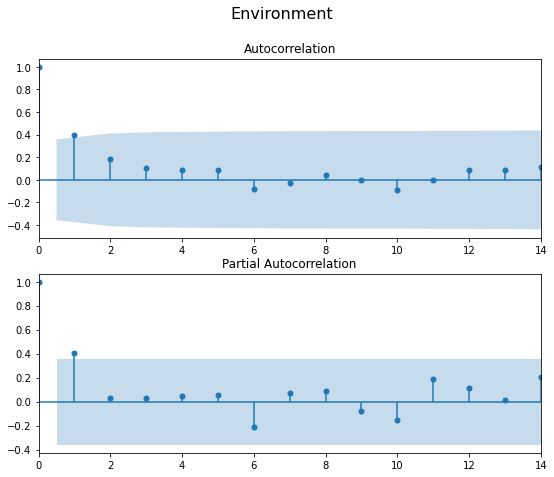

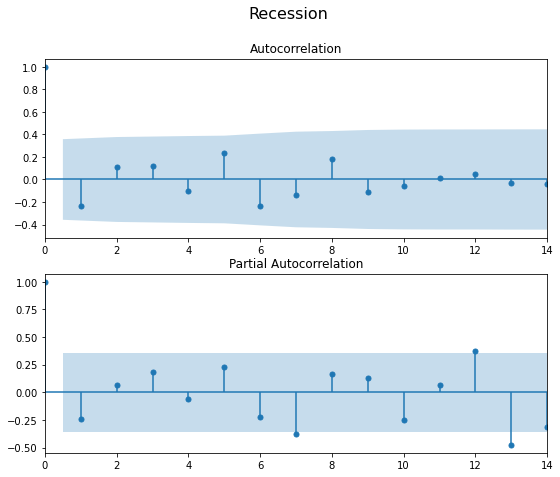

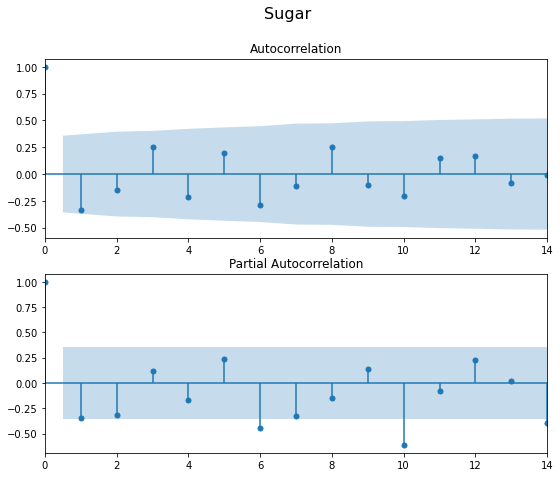

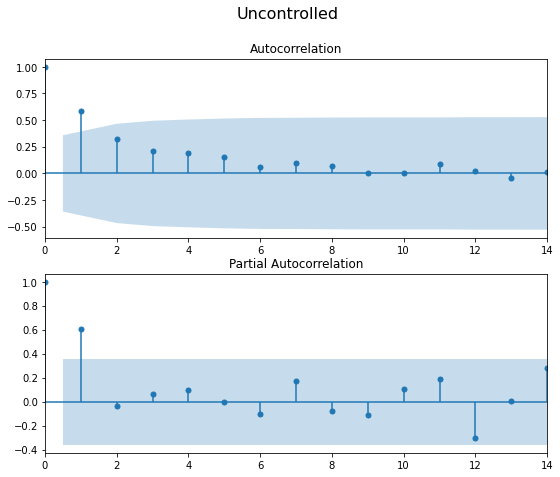

In [13]:
# look at acf and pacf of transformed annual maxima
for col in historical_sevenQ.columns:
    if col not in ["Hydropower", "Cotton"]:
        fig = plt.figure()
        fig.suptitle(col, fontsize=16)
        ax = fig.add_subplot(2,1,1)
        sm.graphics.tsa.plot_acf(historical_sevenQ[col],ax=ax)
        ax.set_xlim([0,14])

        ax = fig.add_subplot(2,1,2)
        sm.graphics.tsa.plot_pacf(historical_sevenQ[col],ax = ax, lags=14)
        ax.set_xlim([0,14])

        fig.set_size_inches([9,7.25])
        fig.savefig('../Figures/Historical_ACF_PACF_%s.png' % col)
        fig.show()

Do not need to model autocorrelation for reservoir operations; the uncontrolled scenario shows exponential decay in the ACF and sinusoidal decay in the PACF, so might consider using an ARMA(1,1) model, but will proceed without considering seasonality/cyclces.

#### Test for a Trend

In [14]:
historical_sevenQ['Year'] = historical_sevenQ.index
mod_dict = dict.fromkeys(historical_sevenQ.columns)
for col in Objectives:
    mod = smf.ols(formula='%s ~ Year' %col, data=historical_sevenQ)
    result = mod.fit()
    mod_dict[col] = result

Note that Hydropower and Cotton do not meet normality assumption, so I will ignore these linear models. 

In [15]:
print(mod_dict['Environment'].summary())
print(mod_dict['Recession'].summary())
print(mod_dict['Sugar'].summary())
print(mod_dict['Uncontrolled'].summary())

                            OLS Regression Results                            
Dep. Variable:            Environment   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     13.00
Date:                Thu, 13 May 2021   Prob (F-statistic):            0.00120
Time:                        10:05:02   Log-Likelihood:                -216.47
No. Observations:                  30   AIC:                             436.9
Df Residuals:                      28   BIC:                             439.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.119e+04   1.44e+04     -3.554      0.0

##### Environment:
* Adj-R2 = 0.293
* p-value = 0.001

##### Recession:"
* Adj-R2 = 0.064
* p-value = 0.176

##### Sugarcane:
* Adj-R2 = -0.025
* p-value = 0.599

##### Uncontrolled:
* Adj-R2 =  0.472
* p-value = 0.000

Now I can look at the Mann-Kendall test -- can be used for all operating policies, even those that violate normality assumption.

In [16]:
mk_dict = dict.fromkeys(Objectives)
for col in Objectives:
    trend, h, p, z = mk_test(np.array(historical_sevenQ[col]))
    mk_dict[col] = [trend,p]

In [17]:
mk_dict

{'Hydropower': ['increasing', 0.011467038985101707],
 'Environment': ['increasing', 0.002723885889168942],
 'Recession': ['no trend', 0.06879172817146428],
 'Sugar': ['no trend', 0.8865048064138312],
 'Cotton': ['no trend', 1.0],
 'Uncontrolled': ['increasing', 8.672007523902181e-05]}

As with fitting a linear model, the best policy for Environment and the uncontrolled scenario show a statistically significant trend of increasing seven day low flow and the best policies for Recession and Sugar show no trend. Now we can look at the non-normal low flows: Hydropower, which shows an increasing trend and Cotton, which shows no trend. This lines up with the plot of the seven day low flows: Cotton is 0 the whole time whereas Hydropower low flows are mainly high later on in the timeseries. 

#### Look for Potential Change Points
Start with linear model  

In [18]:
lm_pvals = dict.fromkeys(Objectives)


for col in Objectives:
    historical_sevenQ['Dummy'] = np.ones(len(historical_sevenQ.index))
    p_values = np.ones(len(historical_sevenQ.index))
    mod = smf.ols(formula='%s ~ Dummy' % col, data=historical_sevenQ)
    result = mod.fit()
    p_values[0] = result.pvalues[1]
    for i in range(len(p_values)):
        historical_sevenQ['Dummy'][1989+i] = 0
        mod = smf.ols(formula='%s ~ Dummy' % col, data=historical_sevenQ)
        result = mod.fit()
        p_values[i] = result.pvalues[1]
    lm_pvals[col] = p_values

    
# plt.plot(p_values[0:-1])
# plt.plot([0,len(maxQ['Flow'])],[0.05,0.05])


<ipython-input-18-566969e5de1e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_sevenQ['Dummy'][1989+i] = 0
<ipython-input-18-566969e5de1e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_sevenQ['Dummy'][1989+i] = 0
<ipython-input-18-566969e5de1e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_sevenQ['Dummy'][1989+i] = 0
<ipython-input-18-566969e5de1e>:11: SettingWithCopyWarning: 
A value is tryi

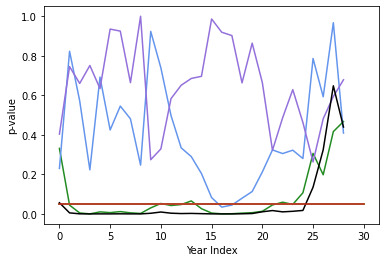

In [19]:
for col in Objectives:
    if col not in ["Hydropower", "Cotton"]:
        plt.plot(lm_pvals[col][0:-1], color = col_dict[col])
        plt.plot([0,len(historical_sevenQ.index)],[0.05,0.05])
        plt.ylabel("p-value")
        plt.xlabel("Year Index")
plt.show()

Environmental Flows and Uncontrolled scenarios have statistically significant change points at almost any time until about 2013 (1989 + 24). Recession has one statistically significant potential change point in 2005 (year index 16). Sugarcane never has a statistically significant change point.

Now use the KS test - it is nonparametric, so I can look at all policies.

In [20]:
ks_pvals = dict.fromkeys(Objectives)
for col in Objectives:
    p_values = np.ones(len(historical_sevenQ[col]) -1)
    for i in range(len(historical_sevenQ[col]) - 1):
        _, p_values[i] = ss.ks_2samp(historical_sevenQ[col].iloc[0:(i+1)],historical_sevenQ[col].iloc[(i+1)::])
    ks_pvals[col] = p_values

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


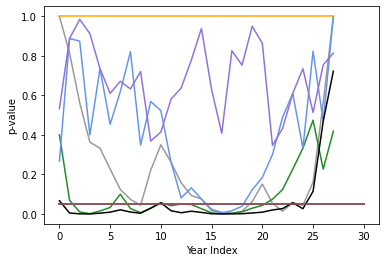

In [21]:
for col in Objectives:
    print(col)
    plt.plot(ks_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(historical_sevenQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Environmnetal Flows and Uncontrolled statistically significant change points until about 2013 again. Recession has statistically signfiicant change points between about 2003 and 2007; same with hydropower. Cotton has no potential change points, since all values are zeros.

Now use Wilcoxon rank-sum test.

In [22]:
wc_pvals = dict.fromkeys(Objectives)
for col in Objectives:
    p_values = np.ones(len(historical_sevenQ[col]) -1)
    for i in range(len(historical_sevenQ[col]) - 1):
        _, p_values[i] = ss.ranksums(historical_sevenQ[col].iloc[0:(i+1)],historical_sevenQ[col].iloc[(i+1)::])
    wc_pvals[col] = p_values

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


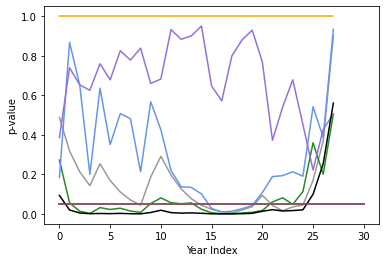

In [23]:
for col in Objectives:
    print(col)
    plt.plot(wc_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(historical_sevenQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Looks really similar to p-values for KS test. 

## 2. Climate Change
### EDA

In [55]:
gfdl_files = [f for f in sorted(glob('../Data/GFDL*'))]
ccsm4_files = [f for f in sorted(glob('../Data/CCSM4*'))]
GFDL_allQ = pd.DataFrame()
CCSM_allQ = pd.DataFrame()

for g,c in zip(gfdl_files, ccsm4_files):
    df_g = pd.read_csv(g)
    df_c = pd.read_csv(c)
    GFDL_allQ[os.path.basename(g)[:-4]] = df_g['flow']
    CCSM_allQ[os.path.basename(c)[:-4]] = df_c['flow']

GFDL_allQ.index = pd.to_datetime(df_g.date)
CCSM_allQ.index = pd.to_datetime(df_c.date)

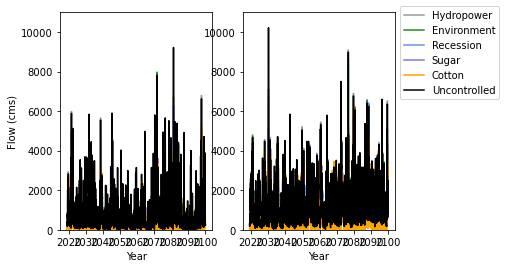

In [56]:
Objectives = ['Hydropower', 'Environment', 'Recession', 'Sugar', 'Cotton', 'Uncontrolled'] 
colors = ['#999999', "forestgreen", "cornflowerblue", "mediumpurple", "orange", "black"]
col_dict = {'Hydropower':'#999999', 'Environment':'forestgreen', 'Recession':'cornflowerblue', 'Sugar':'mediumpurple', 'Cotton':'orange', 'Uncontrolled':'black'}
GFDL_allQ.columns = Objectives
CCSM_allQ.columns = Objectives

fig, (ax1, ax2) = plt.subplots(1,2)
for col in Objectives:
    ax1.plot(GFDL_allQ.index, GFDL_allQ[col], label=col, color=col_dict[col])
    ax2.plot(CCSM_allQ.index, CCSM_allQ[col], label=col, color=col_dict[col])
plt.legend(bbox_to_anchor=(1,1.05))
ax1.set_xlabel("Year")
ax1.set_ylabel("Flow (cms)")
ax2.set_xlabel("Year")
for ax in [ax1, ax2]:
    ax.set_ylim(0,11000)
plt.show()

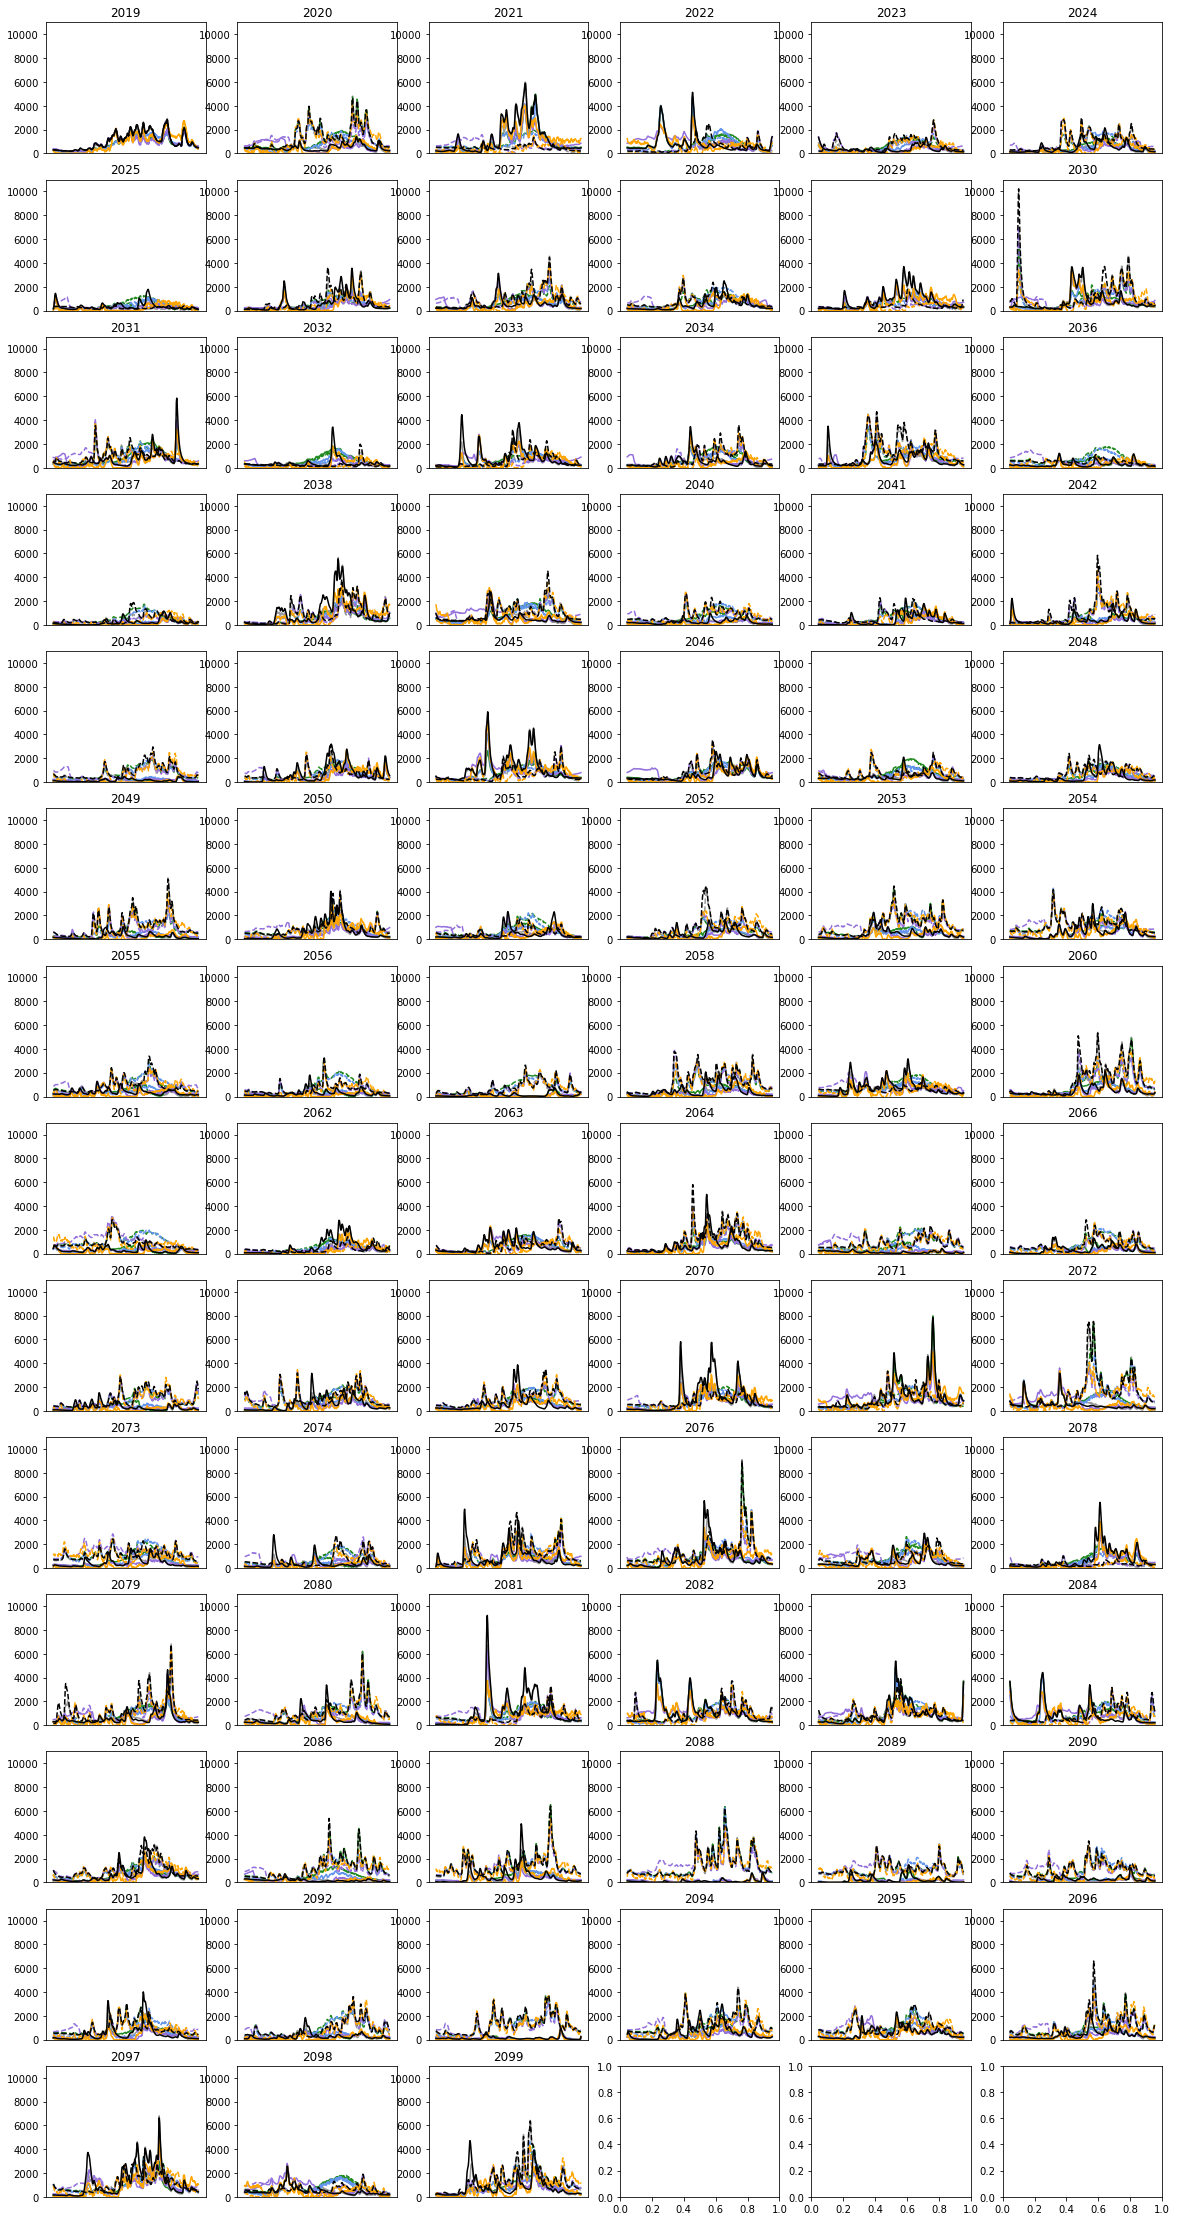

In [57]:
fig, axes = plt.subplots(14,6)
fig.set_size_inches(20,40)
for col in Objectives:
    for year,(a,ax) in zip(GFDL_allQ.index.year.unique(), enumerate(axes.flat)):
        df_g = GFDL_allQ[GFDL_allQ.index.year == year]
        df_c = CCSM_allQ[GFDL_allQ.index.year == year]
        ax.plot(df_g.index, df_g[col], color=col_dict[col])
        ax.plot(df_c.index, df_c[col], color=col_dict[col], linestyle='dashed')
        ax.set_ylim(0,11000)
        ax.xaxis.set_ticks([])
        ax.set_title(year)

Climate change clearly is increasing high flows, suggesting that some trend detection of high flows may be necessary as well! For now, we'll keep looking at the low flows. 

### Seven day low flows

In [58]:
GFDL_allQ['Year'] = GFDL_allQ.index.year 
CCSM_allQ['Year'] = CCSM_allQ.index.year

# calculate sevenQ for each year - CC 
GFDL_sevenQ = pd.DataFrame()
CCSM_sevenQ = pd.DataFrame()
for col in Objectives:
    print(col)
    GFDL_sevenQ[col] = sevenQ(GFDL_allQ, col, 2100) 
    CCSM_sevenQ[col] = sevenQ(CCSM_allQ, col, 2100) 

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


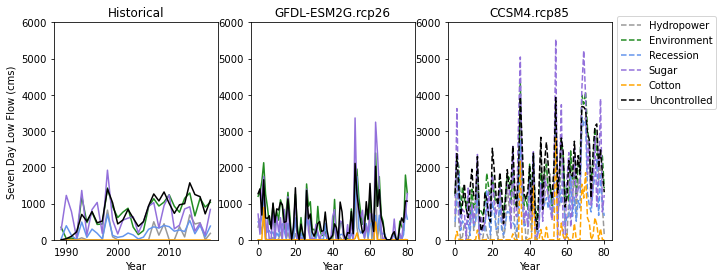

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(10,4)
for col in Objectives:
    ax1.plot(historical_sevenQ.index, historical_sevenQ[col], label=col, color=col_dict[col])
    ax2.plot(GFDL_sevenQ.index, GFDL_sevenQ[col], label=col, color=col_dict[col])
    ax3.plot(CCSM_sevenQ.index, CCSM_sevenQ[col], label=col, color=col_dict[col], linestyle='dashed')
    
plt.legend(bbox_to_anchor=(1,1.05))
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Year")
    ax.set_ylim(0,6000)
ax1.set_ylabel("Seven Day Low Flow (cms)")
ax1.set_title("Historical")
ax2.set_title("GFDL-ESM2G.rcp26")
ax3.set_title("CCSM4.rcp85")
plt.show()

Off the bat, we can see some major differences between historical and climate change. Reservoir operations under GFDL-ESM2G RCP 2.6 tend to decrease seven day low flows compared to the baseline scenario. GFDL-ESM2G RCP 2.6 has some higher years but many lower years than historical. Same goes for CCSM4.rcp85, but low flows seem to have an increasing trend for CCSM4.rcp865 ( more than triple historical seven day low flows). 

### Trend Analysis Seven Day Low Flows
Start by checking normality assumption. 

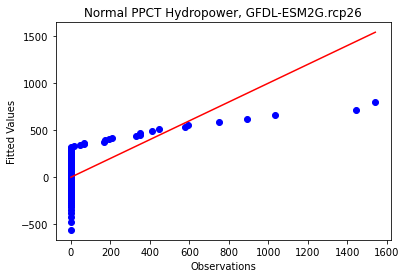

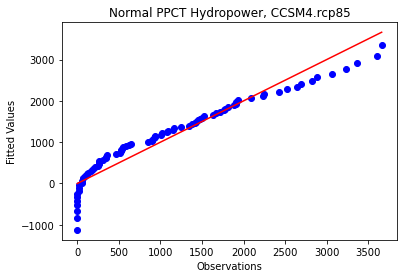

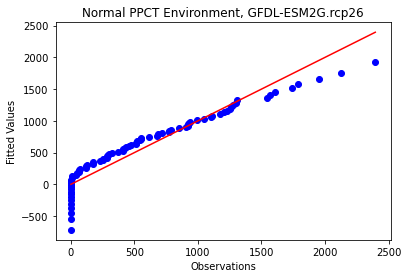

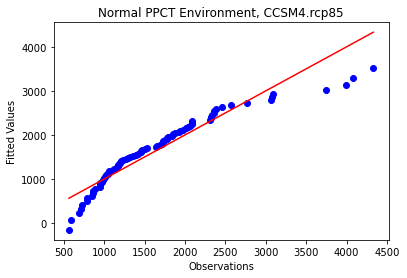

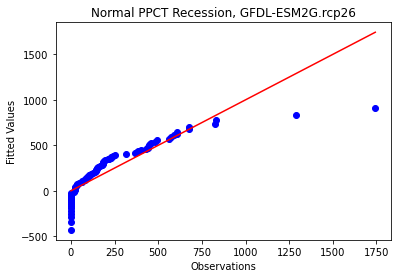

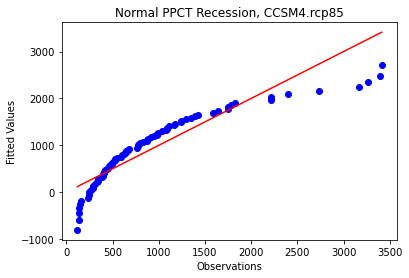

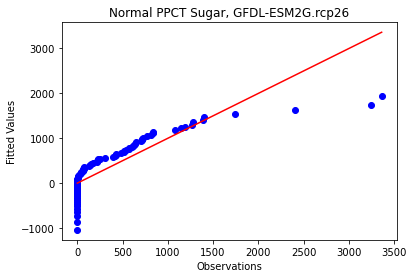

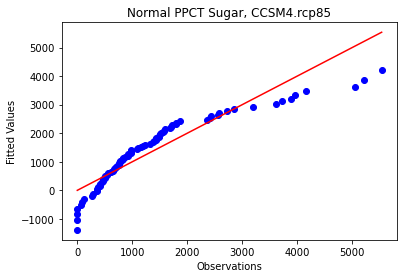

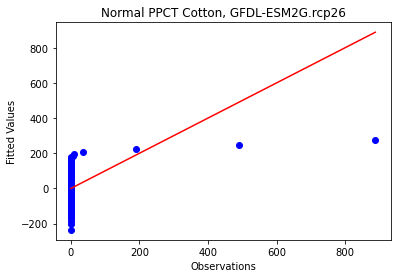

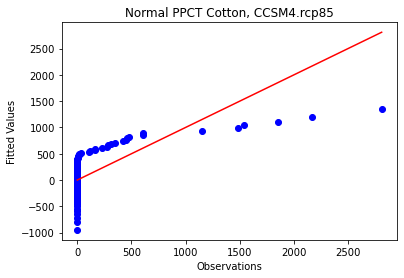

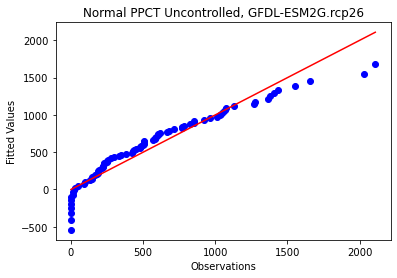

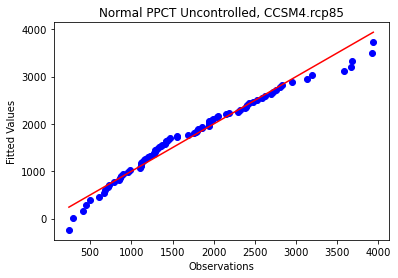

In [29]:
GFDL_rhos = dict.fromkeys(Objectives)
GFDL_p_vals = dict.fromkeys(Objectives)
CCSM_rhos = dict.fromkeys(Objectives)
CCSM_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_sevenQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_sevenQ[col], mu, sigma, 'Normal PPCT %s, %s' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_%s_%s.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_rhos[col] = rho
    GFDL_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_sevenQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_sevenQ[col], mu, sigma, 'Normal PPCT %s, %s' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_%s_%s.png'  % (col, 'CCSM5.rcp85'))
    CCSM_rhos[col] = rho
    CCSM_p_vals[col] = p_value

In [30]:
print(GFDL_p_vals)
print(CCSM_p_vals)

{'Hydropower': 0.0, 'Environment': 0.0, 'Recession': 0.0, 'Sugar': 0.0, 'Cotton': 0.0, 'Uncontrolled': 0.0}
{'Hydropower': 0.00039999999999995595, 'Environment': 9.999999999998899e-05, 'Recession': 0.0, 'Sugar': 0.0, 'Cotton': 0.0, 'Uncontrolled': 0.07150000000000001}


We'll need to transform the data. 

In [31]:
GFDL_bc = pd.DataFrame()
CCSM_bc = pd.DataFrame()

GFDL_lambdas = dict.fromkeys(Objectives)
CCSM_lambdas = dict.fromkeys(Objectives)

for col in Objectives:
    Q_T, llambda = ss.boxcox(GFDL_sevenQ[col] + 0.1)
    GFDL_lambdas[col] = llambda
    GFDL_bc[col] = Q_T
    Q_T, llambda = ss.boxcox(CCSM_sevenQ[col] + 0.1)
    CCSM_bc[col] = Q_T  
    CCSM_lambdas[col] == llambda

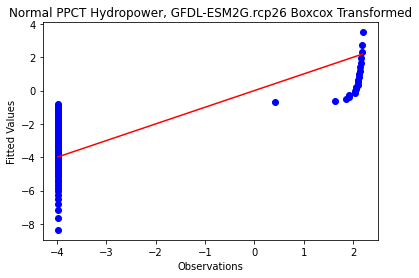

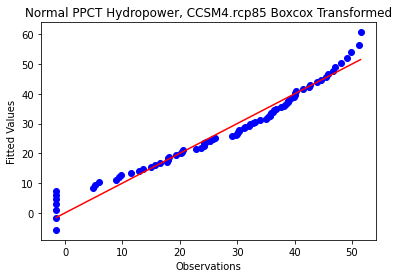

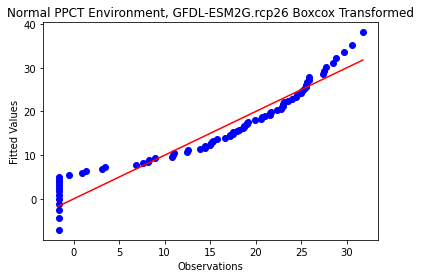

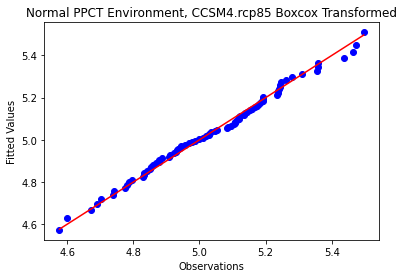

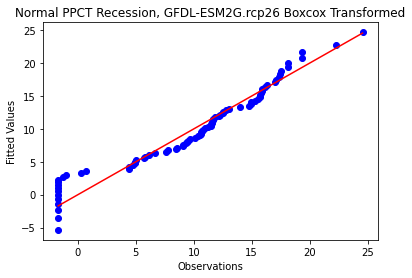

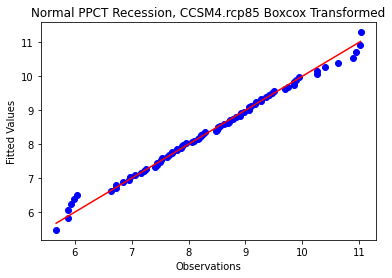

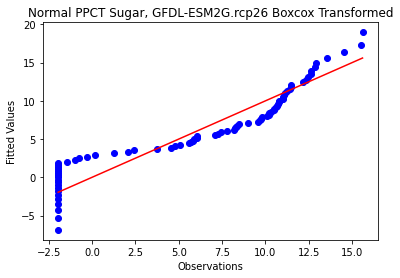

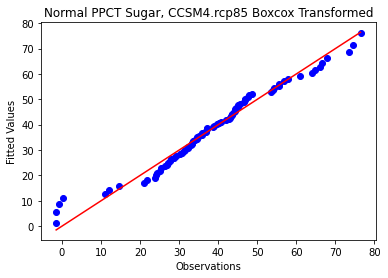

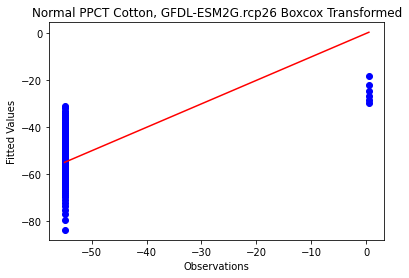

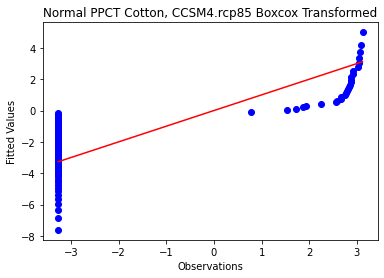

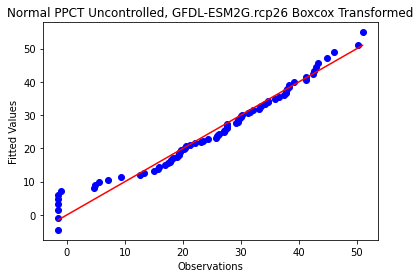

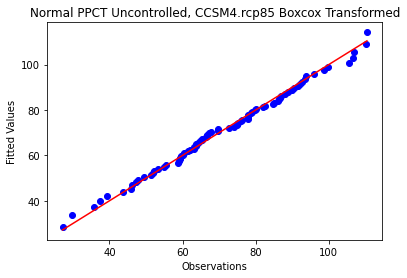

In [32]:
GFDL_bc_rhos = dict.fromkeys(Objectives)
GFDL_bc_p_vals = dict.fromkeys(Objectives)
CCSM_bc_rhos = dict.fromkeys(Objectives)
CCSM_bc_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_BC_%s_%s.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_bc_rhos[col] = rho
    GFDL_bc_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_BC_%s_%s.png'  % (col, 'CCSM5.rcp85'))
    CCSM_bc_rhos[col] = rho
    CCSM_bc_p_vals[col] = p_value

In [33]:
print(GFDL_bc_p_vals)
print(CCSM_bc_p_vals)

{'Hydropower': 0.0, 'Environment': 0.0008000000000000229, 'Recession': 0.007000000000000006, 'Sugar': 9.999999999998899e-05, 'Cotton': 0.0, 'Uncontrolled': 0.09179999999999999}
{'Hydropower': 0.036599999999999966, 'Environment': 0.9381, 'Recession': 0.907, 'Sugar': 0.11329999999999996, 'Cotton': 0.0, 'Uncontrolled': 0.9767}


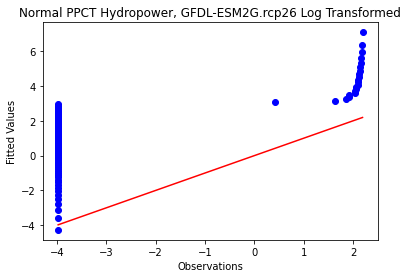

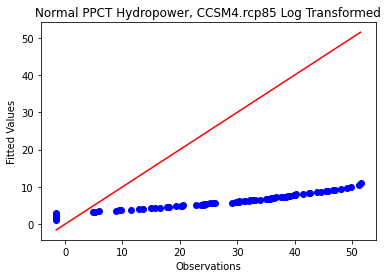

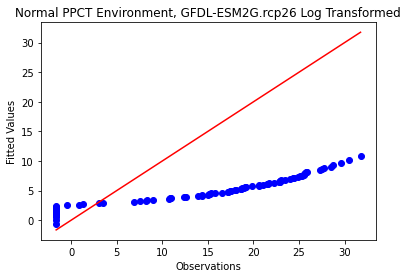

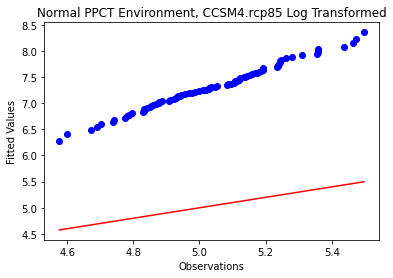

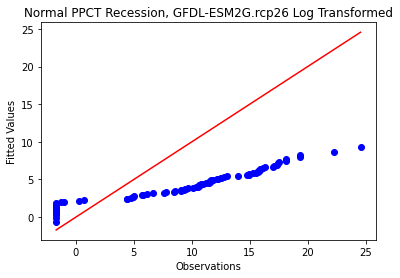

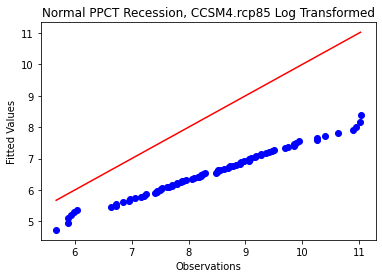

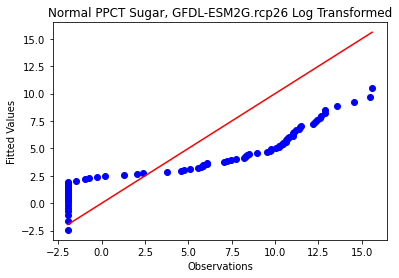

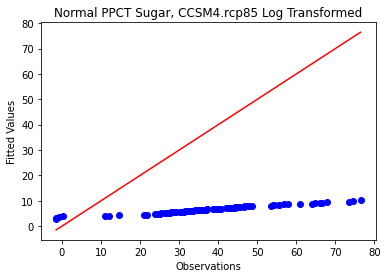

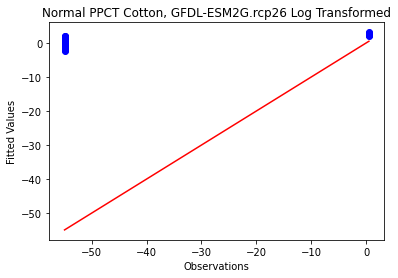

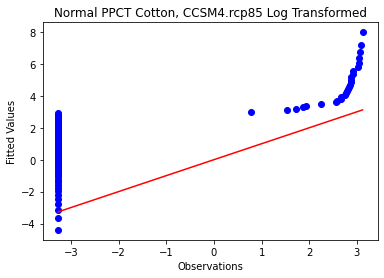

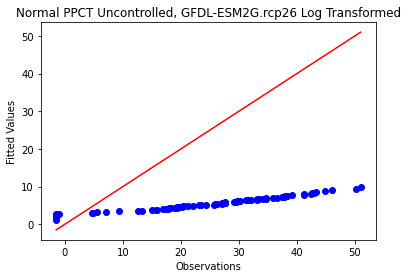

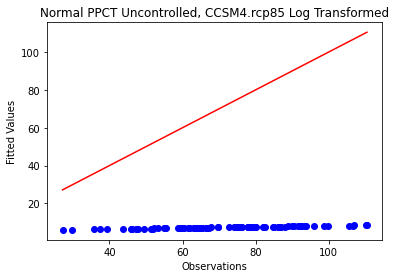

In [34]:
# Try a log transformation 

GFDL_log = np.log(GFDL_sevenQ+1)
CCSM_log = np.log(CCSM_sevenQ + 1)

GFDL_log_p_vals = dict.fromkeys(Objectives)
CCSM_log_p_vals = dict.fromkeys(Objectives)

for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_log[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_bc[col], mu, sigma, 'Normal PPCT %s, %s Log Transformed' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_log_%s_%s.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_log_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_log[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_bc[col], mu, sigma, 'Normal PPCT %s, %s Log Transformed' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_log_%s_%s.png'  % (col, 'CCSM5.rcp85'))
    CCSM_log_p_vals[col] = p_value

Absolutely horrible, boxcox at least looks ok...

Since can't really transform to normality, use non-parametric tests for trend detection. Mann Kendall Test:

In [35]:
GFDL_mk_dict = dict.fromkeys(Objectives)
CCSM_mk_dict = dict.fromkeys(Objectives)

for col in Objectives:
    trend, h, p, z = mk_test(np.array(GFDL_sevenQ[col]))
    GFDL_mk_dict[col] = [trend,p]
    trend, h, p, z = mk_test(np.array(CCSM_sevenQ[col]))
    CCSM_mk_dict[col] = [trend,p]

In [36]:
print(GFDL_mk_dict)
print(CCSM_mk_dict)

{'Hydropower': ['decreasing', 0.02623782163894739], 'Environment': ['decreasing', 0.03608814535152893], 'Recession': ['no trend', 0.10063686821796036], 'Sugar': ['no trend', 0.9280163300760038], 'Cotton': ['no trend', 0.20093271565688298], 'Uncontrolled': ['no trend', 0.05216384501497062]}
{'Hydropower': ['increasing', 1.361121434895196e-06], 'Environment': ['increasing', 2.470376045726752e-06], 'Recession': ['increasing', 1.2080486393228895e-05], 'Sugar': ['increasing', 0.0015515236589807024], 'Cotton': ['increasing', 0.0014949849357033251], 'Uncontrolled': ['increasing', 1.0795163908783323e-05]}


Now look at potential change points using non-parametric tests.

In [37]:
GFDL_ks_pvals = dict.fromkeys(Objectives)
CCSM_ks_pvals = dict.fromkeys(Objectives)

def ks_test(df, col):
    p_values = np.ones(len(df[col]) -1)
    for i in range(len(df[col]) - 1):
        _, p_values[i] = ss.ks_2samp(df[col].iloc[0:(i+1)],df[col].iloc[(i+1)::])
    return p_values

for col in Objectives:
    GFDL_ks_pvals[col] = ks_test(GFDL_sevenQ, col)
    CCSM_ks_pvals[col] = ks_test(CCSM_sevenQ, col)
    

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


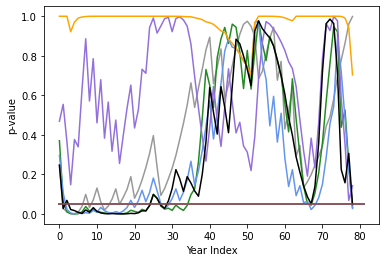

In [38]:
for col in Objectives:
    print(col)
    plt.plot(GFDL_ks_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(GFDL_sevenQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


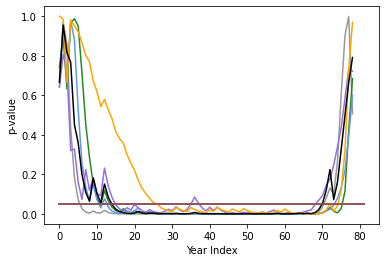

In [39]:
for col in Objectives:
    print(col)
    plt.plot(CCSM_ks_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(CCSM_sevenQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

## 3. Full Time Period

In [61]:
GFDL_sevenQ.index = range(2019, 2100)
CCSM_sevenQ.index = range(2019, 2100)

In [62]:
GFDL_sevenQ = pd.concat([historical_sevenQ, GFDL_sevenQ])
CCSM_sevenQ = pd.concat([historical_sevenQ, CCSM_sevenQ])

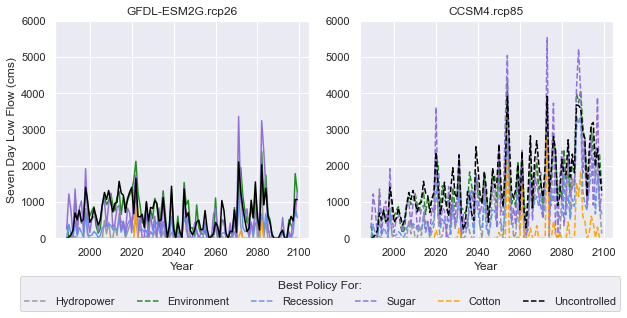

In [93]:
import seaborn as sns
sns.set()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10,4)
for col in Objectives:
    ax1.plot(GFDL_sevenQ.index, GFDL_sevenQ[col], label=col, color=col_dict[col])
    ax2.plot(CCSM_sevenQ.index, CCSM_sevenQ[col], label=col, color=col_dict[col], linestyle='dashed')
    
plt.legend(ncol = 7, bbox_to_anchor=(1.05,-.15), title="Best Policy For:")
for ax in [ax1, ax2]:
    ax.set_xlabel("Year")
    ax.set_ylim(0,6000)
ax1.set_ylabel("Seven Day Low Flow (cms)")
ax1.set_title("GFDL-ESM2G.rcp26")
ax2.set_title("CCSM4.rcp85")
plt.savefig('../Figures/sevenQ.png', bbox_inches='tight')
plt.show()

### Trend Detection
Start by testing for normality:

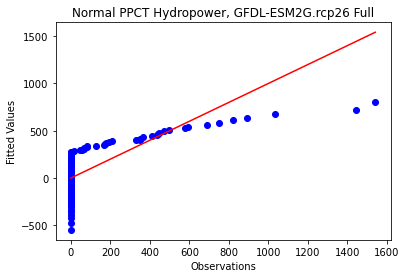

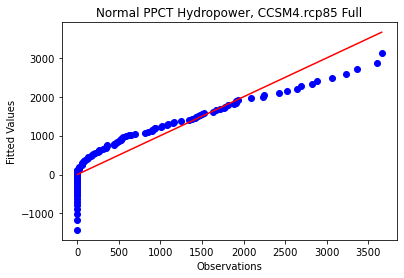

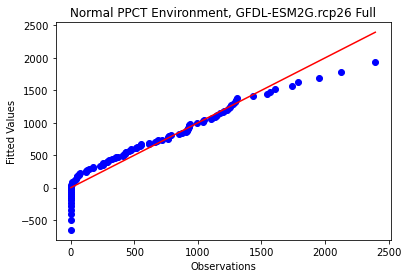

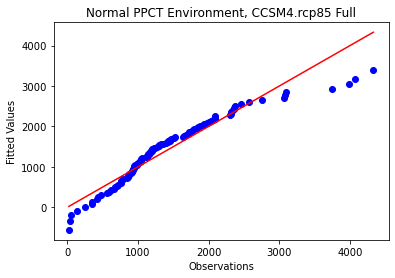

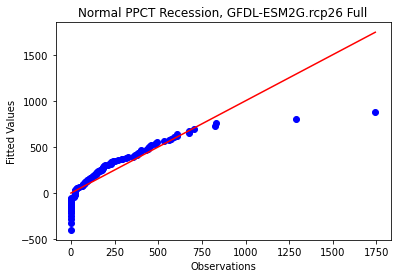

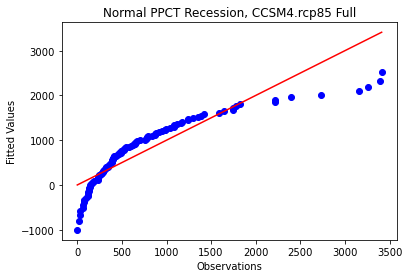

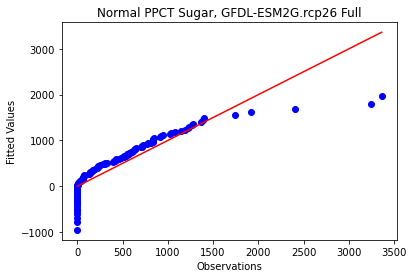

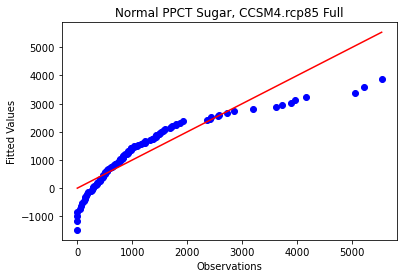

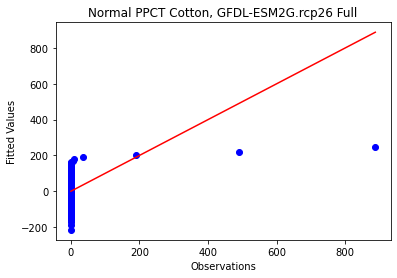

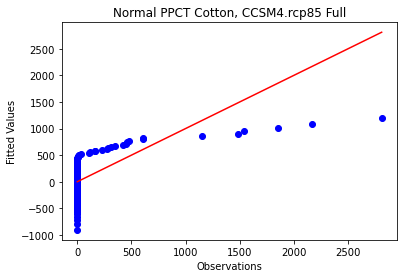

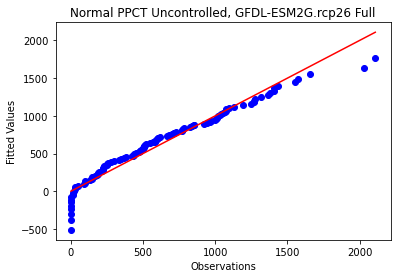

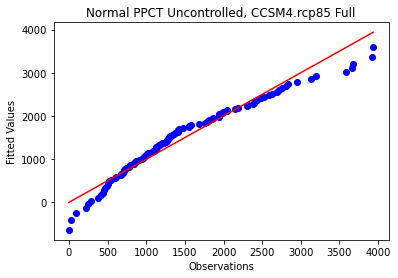

In [65]:
GFDL_p_vals = dict.fromkeys(Objectives)
CCSM_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_sevenQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_sevenQ[col], mu, sigma, 'Normal PPCT %s, %s Full' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_%s_%s_sevenQfull.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_sevenQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_sevenQ[col], mu, sigma, 'Normal PPCT %s, %s Full' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_%s_%s_sevenQfull.png'  % (col, 'CCSM5.rcp85'))
    CCSM_p_vals[col] = p_value

In [67]:
print(GFDL_p_vals)
print(CCSM_p_vals)

{'Hydropower': 0.0, 'Environment': 9.999999999998899e-05, 'Recession': 0.0, 'Sugar': 0.0, 'Cotton': 0.0, 'Uncontrolled': 0.0013999999999999568}
{'Hydropower': 0.0, 'Environment': 9.999999999998899e-05, 'Recession': 0.0, 'Sugar': 0.0, 'Cotton': 0.0, 'Uncontrolled': 0.0020000000000000018}


In [68]:
GFDL_bc = pd.DataFrame()
CCSM_bc = pd.DataFrame()

GFDL_lambdas = dict.fromkeys(Objectives)
CCSM_lambdas = dict.fromkeys(Objectives)

for col in Objectives:
    Q_T, llambda = ss.boxcox(GFDL_sevenQ[col] + 0.1)
    GFDL_lambdas[col] = llambda
    GFDL_bc[col] = Q_T
    Q_T, llambda = ss.boxcox(CCSM_sevenQ[col] + 0.1)
    CCSM_bc[col] = Q_T  
    CCSM_lambdas[col] == llambda

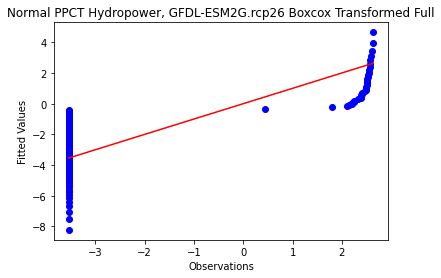

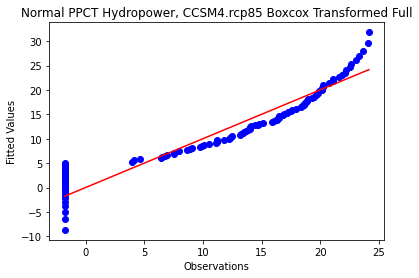

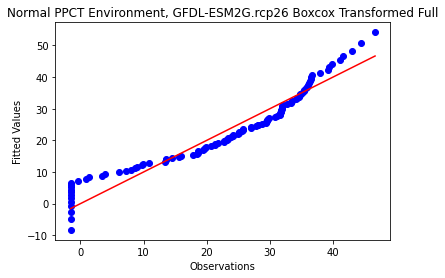

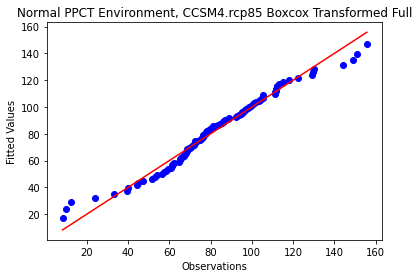

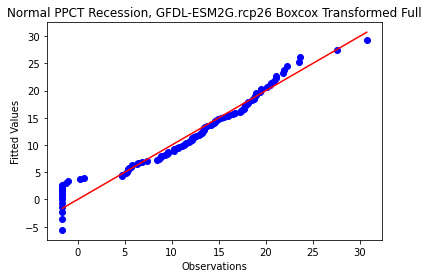

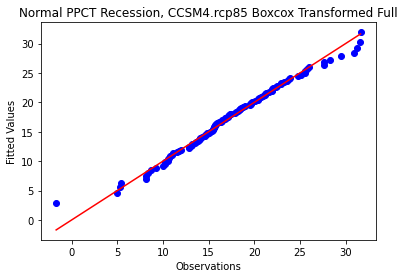

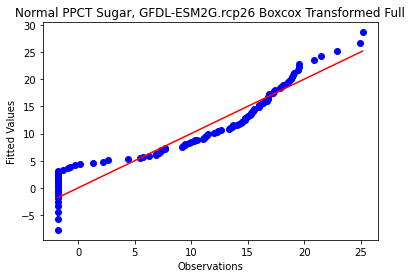

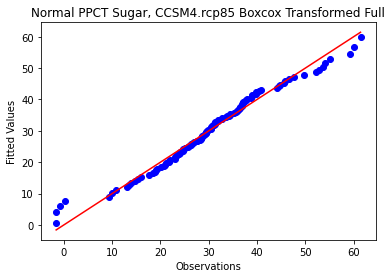

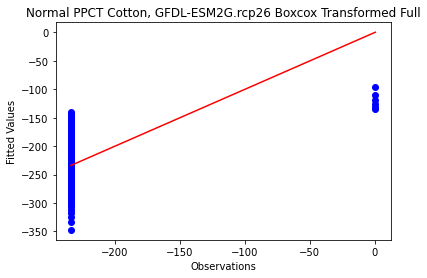

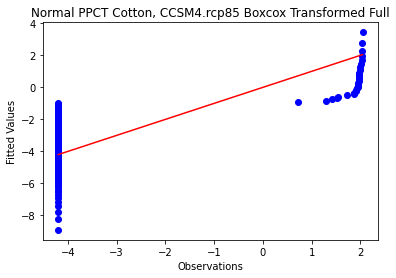

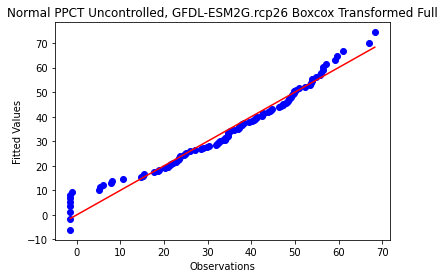

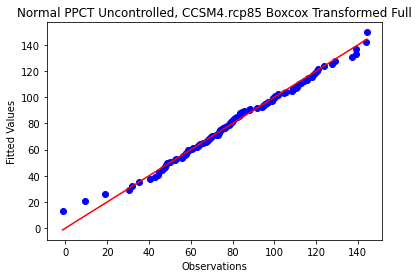

In [69]:
GFDL_bc_p_vals = dict.fromkeys(Objectives)
CCSM_bc_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed Full' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_BC_%s_%s_sevenQFull.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_bc_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed Full' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_BC_%s_%s_sevenQFull.png'  % (col, 'CCSM5.rcp85'))
    CCSM_bc_p_vals[col] = p_value

<ipython-input-70-6bda105f7833>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-70-6bda105f7833>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-70-6bda105f7833>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-70-6bda105f7833>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


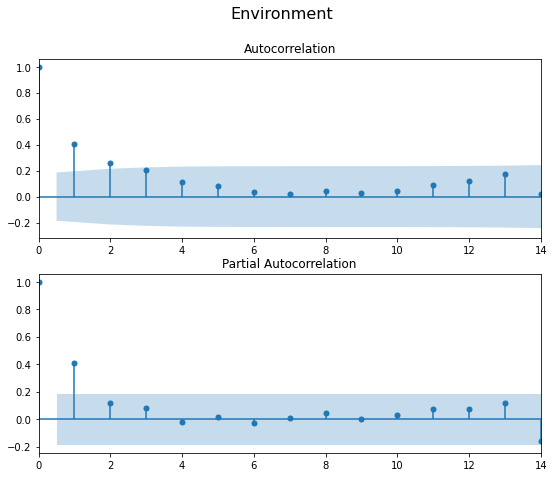

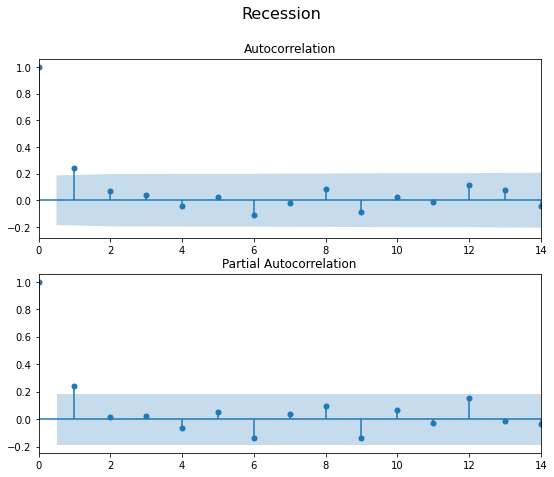

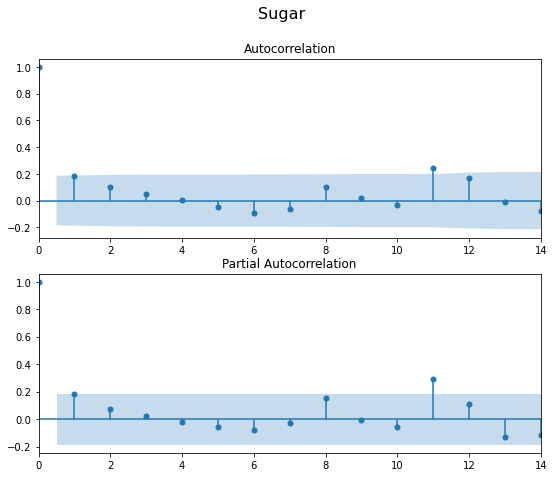

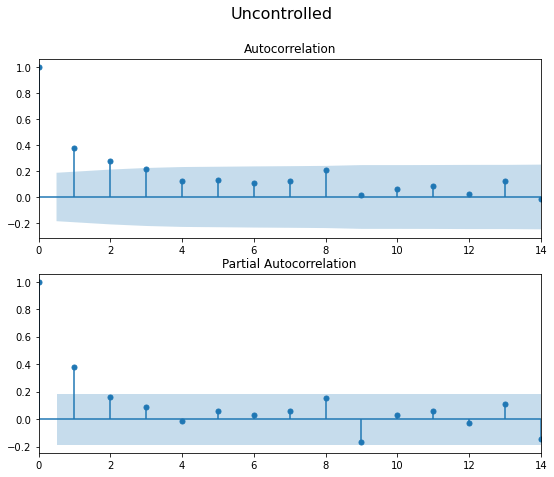

In [70]:
# look at acf and pacf of transformed annual maxima
for col in GFDL_sevenQ.columns:
    if col not in ["Hydropower", "Cotton"]:
        fig = plt.figure()
        fig.suptitle(col, fontsize=16)
        ax = fig.add_subplot(2,1,1)
        sm.graphics.tsa.plot_acf(GFDL_sevenQ[col],ax=ax)
        ax.set_xlim([0,14])

        ax = fig.add_subplot(2,1,2)
        sm.graphics.tsa.plot_pacf(GFDL_sevenQ[col],ax = ax, lags=14)
        ax.set_xlim([0,14])

        fig.set_size_inches([9,7.25])
        fig.savefig('../Figures/GFDL_ACF_PACF_%s.png' % col)
        fig.show()

Perhaps an AR(1) or ARMA(1,1)? But not really for all of them; most insignificant, so will proceed without removing cycles/seasons.

<ipython-input-71-cfe080fc7071>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-71-cfe080fc7071>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-71-cfe080fc7071>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-71-cfe080fc7071>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


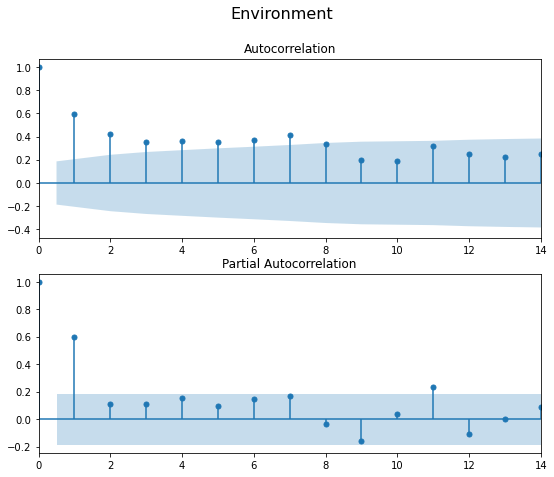

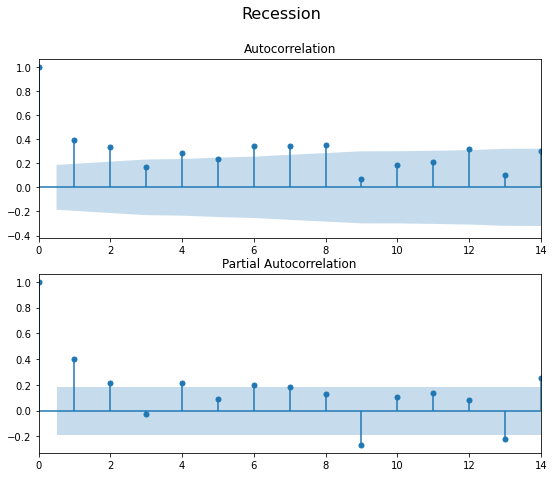

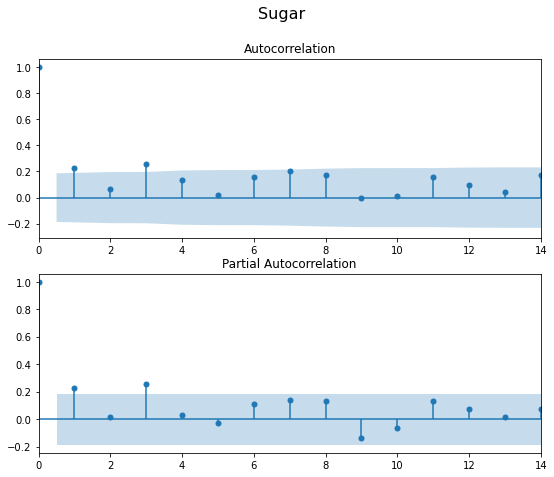

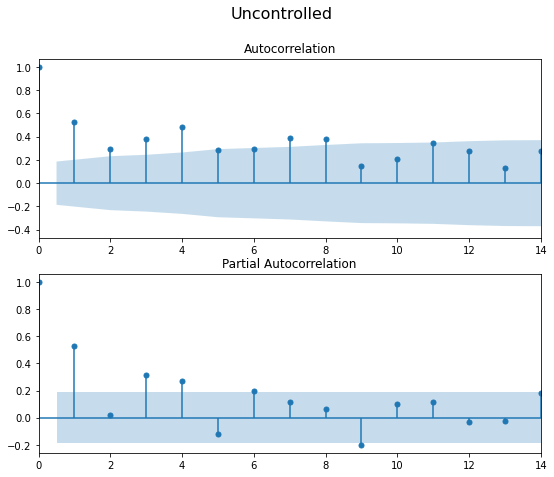

In [71]:
# look at acf and pacf of transformed annual maxima
for col in CCSM_sevenQ.columns:
    if col not in ["Hydropower", "Cotton"]:
        fig = plt.figure()
        fig.suptitle(col, fontsize=16)
        ax = fig.add_subplot(2,1,1)
        sm.graphics.tsa.plot_acf(CCSM_sevenQ[col],ax=ax)
        ax.set_xlim([0,14])

        ax = fig.add_subplot(2,1,2)
        sm.graphics.tsa.plot_pacf(CCSM_sevenQ[col],ax = ax, lags=14)
        ax.set_xlim([0,14])

        fig.set_size_inches([9,7.25])
        fig.savefig('../Figures/CCSM_ACF_PACF_%s.png' % col)
        fig.show()

No clear path forward here. 

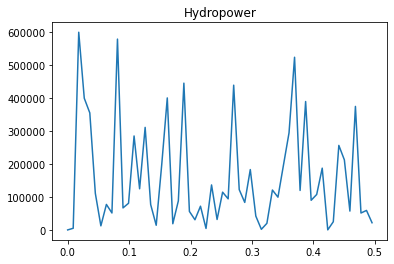

[ 55.5         12.33333333   2.70731707   5.28571429   3.7
   6.16666667  37.           2.58139535   2.13461538  27.75
   7.92857143   2.775        9.25         2.26530612   2.22
   6.52941176   2.84615385   2.41304348   3.36363636   4.26923077
   8.53846154   3.58064516   3.           2.64285714   3.96428571
  22.2          2.46666667   2.92105263   3.82758621   2.52272727
   5.55         3.46875     10.09090909  15.85714286   7.4
   4.625       11.1          2.05555556   2.17647059   5.04545455
  13.875        2.09433962   3.26470588   4.11111111   4.82608696
   2.3125       2.01818182   3.08333333   5.84210526   6.9375
  18.5        111.           4.44         3.17142857   2.36170213]


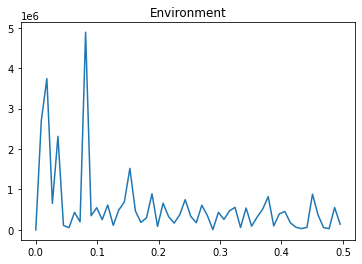

[ 12.33333333  55.5        111.          27.75         6.52941176
   5.28571429   2.22         2.64285714   4.11111111   6.9375
   4.82608696  37.           8.53846154   3.7          3.08333333
   2.05555556  10.09090909   2.92105263   2.70731707   7.4
   3.17142857   6.16666667   2.46666667   3.36363636  15.85714286
   2.52272727   4.26923077   2.17647059   3.58064516  11.1
   3.96428571   4.625        2.775        5.55         3.26470588
   9.25        13.875        5.84210526   3.82758621   2.41304348
   4.44         2.01818182   7.92857143  22.2          2.58139535
   2.84615385   5.04545455   2.36170213   2.26530612   3.
   2.13461538  18.5          2.3125       2.09433962   3.46875   ]


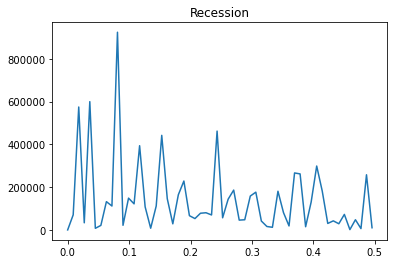

[ 12.33333333  27.75        55.5          4.11111111   6.52941176
   8.53846154   2.46666667   2.70731707   2.64285714   2.05555556
   5.28571429   3.7          2.41304348   2.92105263   3.26470588
   5.55         3.36363636  10.09090909   6.16666667   3.82758621
  15.85714286   2.52272727   9.25        13.875        6.9375
   7.92857143   2.84615385   4.44         4.625        2.22
 111.           4.26923077   5.04545455   3.96428571   4.82608696
   2.13461538   3.46875      3.58064516   2.3125       3.17142857
  37.           2.36170213   2.26530612   5.84210526  11.1
  18.5          2.775        3.08333333   2.58139535   3.
   2.01818182   7.4         22.2          2.09433962   2.17647059]


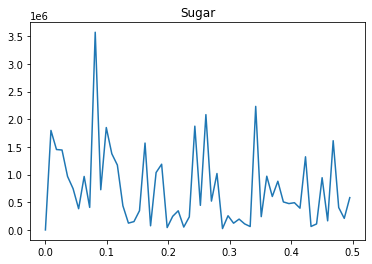

[ 12.33333333   2.92105263   3.82758621   4.11111111  10.09090909
 111.           2.13461538   6.16666667  55.5         37.
   9.25         2.36170213   5.28571429   8.53846154   5.55
   3.58064516   2.775       27.75        15.85714286   2.22
   2.64285714  22.2         11.1          2.70731707   2.01818182
   3.7          2.58139535   2.46666667   2.52272727   3.96428571
   7.92857143  13.875        2.09433962   2.41304348  18.5
   6.52941176   4.625        3.36363636   4.82608696   2.84615385
   4.26923077   2.05555556   3.17142857   2.17647059   6.9375
   7.4          3.26470588   3.08333333   2.26530612   5.84210526
   2.3125       3.           4.44         5.04545455   3.46875   ]


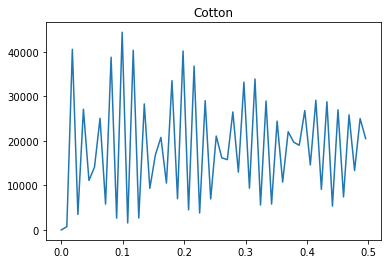

[ 10.09090909  55.5          8.53846154   5.04545455  12.33333333
   4.625        3.17142857   5.55         3.36363636   2.41304348
   4.26923077   3.           2.3125       7.4         27.75
   2.22         2.52272727   3.58064516   2.13461538  15.85714286
   2.05555556   2.84615385   2.70731707   3.96428571   6.16666667
   2.01818182   2.64285714   2.58139535   6.52941176   3.82758621
   3.7          2.46666667  18.5          2.09433962   3.46875
  22.2          2.775        5.84210526   3.26470588   6.9375
   2.36170213   2.17647059   5.28571429   4.11111111   2.92105263
  13.875        3.08333333   2.26530612   4.82608696   4.44
  37.           7.92857143  11.1          9.25       111.        ]


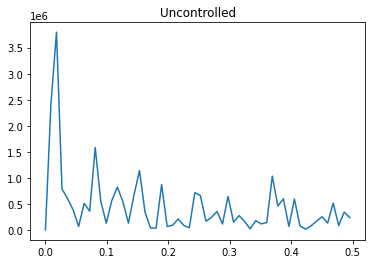

[ 55.5        111.          12.33333333   6.52941176   2.70731707
   5.28571429   8.53846154  37.           4.11111111   6.9375
   3.96428571   3.36363636  27.75         2.58139535   2.46666667
   9.25        11.1          7.92857143   2.13461538  15.85714286
   2.64285714  22.2         13.875        3.58064516   2.05555556
   6.16666667   3.17142857   2.22         3.7          2.01818182
   4.625        2.92105263   2.26530612   3.82758621   3.08333333
   3.26470588   2.775        2.17647059   7.4         10.09090909
   2.84615385   3.46875      4.82608696   4.44         2.09433962
   2.3125       2.41304348   2.52272727  18.5          5.04545455
   4.26923077   5.55         5.84210526   3.           2.36170213]


In [76]:
# look at periodogram of transformed annual maxima
for col in GFDL_sevenQ.columns:
    f, P = scipy.signal.periodogram(GFDL_sevenQ[col])
    plt.plot(f,P)
    plt.title(col)
    plt.show()

    Psorted = np.argsort(P)[::-1] # sort from largest to smallest
    Psorted = Psorted[Psorted > 0] # filter 0 vals
    T = 1/f[Psorted] # find corresponding periods
    print(T)

In [74]:
T

array([ 55.5       , 111.        ,  12.33333333,   6.52941176,
         2.70731707,   5.28571429,   8.53846154,  37.        ,
         4.11111111,   6.9375    ,   3.96428571,   3.36363636,
        27.75      ,   2.58139535,   2.46666667,   9.25      ,
        11.1       ,   7.92857143,   2.13461538,  15.85714286,
         2.64285714,  22.2       ,  13.875     ,   3.58064516,
         2.05555556,   6.16666667,   3.17142857,   2.22      ,
         3.7       ,   2.01818182,   4.625     ,   2.92105263,
         2.26530612,   3.82758621,   3.08333333,   3.26470588,
         2.775     ,   2.17647059,   7.4       ,  10.09090909,
         2.84615385,   3.46875   ,   4.82608696,   4.44      ,
         2.09433962,   2.3125    ,   2.41304348,   2.52272727,
        18.5       ,   5.04545455,   4.26923077,   5.55      ,
         5.84210526,   3.        ,   2.36170213])

Mann Kendall Trend Test:

In [77]:
GFDL_mk_dict = dict.fromkeys(Objectives)
CCSM_mk_dict = dict.fromkeys(Objectives)

for col in Objectives:
    trend, h, p, z = mk_test(np.array(GFDL_sevenQ[col]))
    GFDL_mk_dict[col] = [trend,p]
    trend, h, p, z = mk_test(np.array(CCSM_sevenQ[col]))
    CCSM_mk_dict[col] = [trend,p]

In [78]:
print(GFDL_mk_dict)
print(CCSM_mk_dict)

{'Hydropower': ['decreasing', 0.046283901278008965], 'Environment': ['decreasing', 0.022019342310722667], 'Recession': ['no trend', 0.13374713633886404], 'Sugar': ['decreasing', 0.008556703135839117], 'Cotton': ['increasing', 0.035875153491639944], 'Uncontrolled': ['decreasing', 0.01276952165660461]}
{'Hydropower': ['increasing', 4.440892098500626e-15], 'Environment': ['increasing', 2.4424906541753444e-15], 'Recession': ['increasing', 8.659739592076221e-15], 'Sugar': ['increasing', 8.505527145707958e-06], 'Cotton': ['increasing', 7.143782119189979e-07], 'Uncontrolled': ['increasing', 3.6193270602780103e-14]}


Change Points

K-S Test:

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


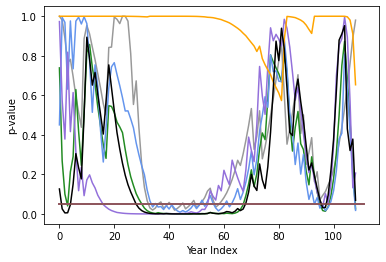

In [79]:
GFDL_ks_pvals = dict.fromkeys(Objectives)
CCSM_ks_pvals = dict.fromkeys(Objectives)

def ks_test(df, col):
    p_values = np.ones(len(df[col]) -1)
    for i in range(len(df[col]) - 1):
        _, p_values[i] = ss.ks_2samp(df[col].iloc[0:(i+1)],df[col].iloc[(i+1)::])
    return p_values

for col in Objectives:
    GFDL_ks_pvals[col] = ks_test(GFDL_sevenQ, col)
    CCSM_ks_pvals[col] = ks_test(CCSM_sevenQ, col)
    

for col in Objectives:
    print(col)
    plt.plot(GFDL_ks_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(GFDL_sevenQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


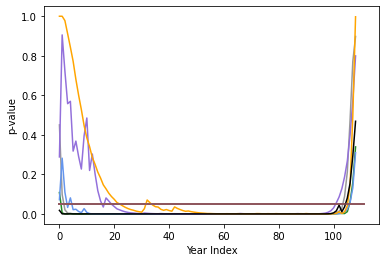

In [80]:
for col in Objectives:
    print(col)
    plt.plot(CCSM_ks_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(CCSM_sevenQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Wilcoxon Rank Sum Test

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


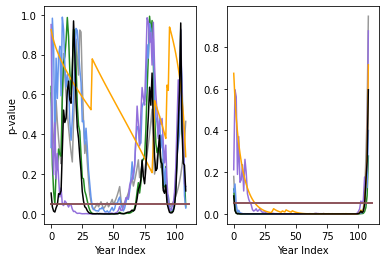

In [84]:
GFDL_wc_pvals = dict.fromkeys(Objectives)
CCSM_wc_pvals = dict.fromkeys(Objectives)

for col in Objectives:
    p_values = np.ones(len(GFDL_sevenQ[col]) -1)
    for i in range(len(GFDL_sevenQ[col]) - 1):
        _, p_values[i] = ss.ranksums(GFDL_sevenQ[col].iloc[0:(i+1)],GFDL_sevenQ[col].iloc[(i+1)::])
    GFDL_wc_pvals[col] = p_values
    p_values = np.ones(len(CCSM_sevenQ[col]) -1)
    for i in range(len(CCSM_sevenQ[col]) - 1):
        _, p_values[i] = ss.ranksums(CCSM_sevenQ[col].iloc[0:(i+1)],CCSM_sevenQ[col].iloc[(i+1)::])
    CCSM_wc_pvals[col] = p_values
    
fig, (ax1, ax2) = plt.subplots(1,2)  
for col in Objectives:
    print(col)
    ax1.plot(GFDL_wc_pvals[col][0:-1], color = col_dict[col])
    ax1.plot([0,len(GFDL_sevenQ.index)],[0.05,0.05])
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    
    ax2.plot(CCSM_wc_pvals[col][0:-1], color = col_dict[col])
    ax2.plot([0,len(CCSM_sevenQ.index)],[0.05,0.05])
    ax2.set_xlabel("Year Index")
plt.show()

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


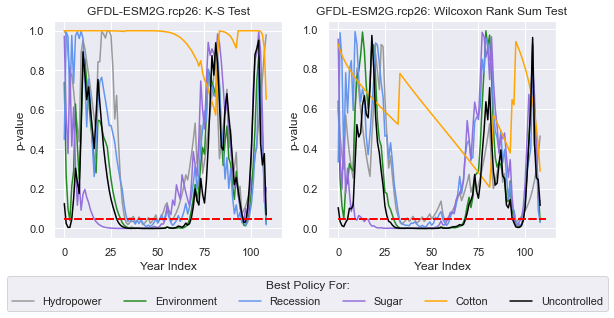

In [95]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(9,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_ks_pvals[col][0:-1], color = col_dict[col], label=col)
    ax1.plot([0,len(GFDL_sevenQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL-ESM2G.rcp26: K-S Test")
    ax2.plot(GFDL_wc_pvals[col][0:-1], color = col_dict[col],label=col)
    ax2.plot([0,len(GFDL_sevenQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("GFDL-ESM2G.rcp26: Wilcoxon Rank Sum Test")
plt.legend(ncol = 6, bbox_to_anchor=(1.25,-.15), title="Best Policy For:")

plt.savefig('../Figures/Dry_GFDL_ChangePoints.png', bbox_inches="tight")

plt.show()

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


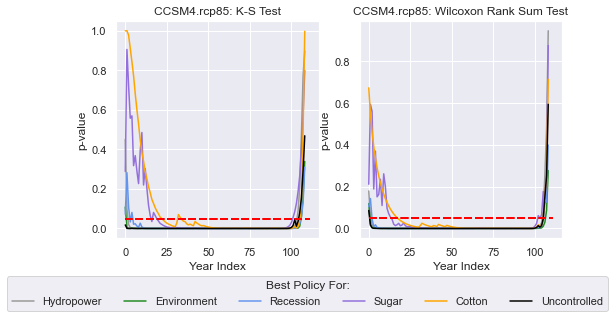

In [97]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(CCSM_ks_pvals[col][0:-1], color = col_dict[col], label=col)
    ax1.plot([0,len(GFDL_sevenQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("CCSM4.rcp85: K-S Test")
    ax2.plot(CCSM_wc_pvals[col][0:-1], color = col_dict[col],label=col)
    ax2.plot([0,len(CCSM_sevenQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM4.rcp85: Wilcoxon Rank Sum Test")
plt.legend(ncol = 6, bbox_to_anchor=(1.25,-.15), title="Best Policy For:")

plt.savefig('../Figures/Dry_CCSM_ChangePoints.png', bbox_inches="tight")
plt.show()